### first pass on API for ASE OOS

use cases:
- low/high degree nodes tend to distord spectral embedding, so omit from original embedding and then add back in with oos
- original graph too big, so make a subgraph and embed, then do oos for the rest
- have graph, embed it, get new graph defined on a larger set of nodes but with the same relationship between vertices. embed new graph with oos because it's generated by the same underlying distribution.

### notes
- add sklearn's exceptions.NotFittedError if we try to predict without fitting?
- for class-based sklearnish APIs, could add an augment_latent_positions toggle to predict if we want to have predicting update the latent positions matrix
- [partial-fit](https://scikit-learn.org/stable/glossary.html#term-partial-fit) could be useful if we want an API for updating our latent positions matrix with oos data?
- sklearn.utils.estimator_checks.check_estimator useful if I want to use the sklearn api
- sklearn.utils.check_array useful for input validation

In [1]:
import numpy as np
from sklearn.utils.validation import check_is_fitted

from graspy.simulations import sbm
from graspy.embed import AdjacencySpectralEmbed
from graspy.embed.base import BaseEmbed
from graspy.plot import heatmap

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 120

In [2]:
# API 1: we just have an OOSEmbedder class
class OOSEmbed(BaseEmbed):
    def __init__(self, Xhat=None):
        # maybe some useful toggles on behavior here?
        self.X_ = Xhat  # TODO: can pass in a precomputed ASE if you want,
                        # in which case `fit` will just use that as its X value.
                        # need some way to get eigenvalues if you pass in precomputed ASE
        pass
    
    def fit(self, X=None, y=None):
        """
        would take some input adjacency matrix X,
        embed it, and add self.pinv_, self.latent_right_,
        and self.singular_values_ to class attributes
        """
        # X \in R^{nxn}. if X is None, use `self.X`. If `self.X` is None, raise an error.
        
        # some code to make self.pinv,
        # input-validation
        # and maybe error checking, etc
        # returns self
        
        # checks on X go here, then
        # grab pinv and make new class attributes
        
        # TODO: break if X is None and self.X_ is None
        
        if self.X_ is None:
            ase = AdjacencySpectralEmbed(n_components=2)  # need some way to change parameters
            ase.fit(X)
            self.X_ = ase.latent_left_.copy()
            self.eig_values_ = ase.singular_values_.copy()
            
        self.pinv_ = self.X_ @ np.diag(1/self.eig_values_)
        
        self.is_fitted_ = True
        
        # add self.X_ \in R^{nxd}, the latent position matrix
        pass


    def predict(self, y):
        """
        Given some latent position matrix X,
        its diagonal eigenvalue matrix D,
        and edge matrix y,
        compute the least-squares estimate for the latent position of y.

        Parameters
        ----------
        y: array
            out-of-sample vectors to embed. nxd
        """
        check_is_fitted(self, 'is_fitted_')
        # input validation
        return y @ self.pinv_
        # maybe toggle for returning either 
        # *just* oos latent positions,
        # or an augmented ASE?

In [3]:
# API 2: we augment the AdjacencySpectralEmbed class with
# a predict method. This was Hayden's idea in the
# issue
from graspy.utils import (
    import_graph,
    is_fully_connected,
    augment_diagonal,
    pass_to_ranks,
    is_unweighted,
)
class AdjacencySpectralEmbed(BaseEmbed):
    r"""
    bla bla bla
    """

    def __init__(
        self,
        n_components=None,
        n_elbows=2,
        algorithm="randomized",
        n_iter=5,
        check_lcc=True,
        diag_aug=True,
    ):
        super().__init__(
            n_components=n_components,
            n_elbows=n_elbows,
            algorithm=algorithm,
            n_iter=n_iter,
            check_lcc=check_lcc,
        )

        if not isinstance(diag_aug, bool):
            raise TypeError("`diag_aug` must be of type bool")
        self.diag_aug = diag_aug

    def fit(self, graph, y=None):
        # would add the pseudoinverse
        # as a class attribute in fit
        """
        bla bla bla
        """
        A = import_graph(graph)

        if self.check_lcc:
            if not is_fully_connected(A):
                msg = (
                    "Input graph is not fully connected. Results may not"
                    + "be optimal. You can compute the largest connected component by"
                    + "using ``graspy.utils.get_lcc``."
                )
                warnings.warn(msg, UserWarning)

        if self.diag_aug:
            A = augment_diagonal(A)

        self._reduce_dim(A)
        self.pinv_ = self.latent_left_ @ (np.diag(1/self.singular_values_))
        self.is_fitted_ = True
        return self
    
    def predict(self, y):
        check_is_fitted(self, 'is_fitted_')
        return y @ self.pinv_

### check true latent position compared to oos embedding as n increases (using OOSEmbed class)

#### make matrix

In [58]:
from graspy.simulations import er_np
from sklearn.metrics.pairwise import euclidean_distances
from tqdm import tqdm

p = .5
distances = {}
for n in tqdm(range(10, 1000, 10)):
    M = er_np(n=n, p=p)

    # separate
    A = M[:-1, :-1]
    a = M[-1, :-1]

    # true latent positions
    ase = AdjacencySpectralEmbed(n_components=2)
    true = ase.fit_transform(M)[-1]

    # predicted latent positions
    oos = OOSEmbed()
    oos.fit(A)
    predicted = oos.predict(a)

    as_ = np.row_stack((true, predicted))
    distance = euclidean_distances(as_)[0, 1]
    distances[n] = distance

100%|██████████| 99/99 [01:20<00:00,  1.23it/s]


In [59]:
distances

{10: 1.1582488527474628,
 20: 0.6908416365403249,
 30: 0.6979894670562591,
 40: 0.137602670169924,
 50: 0.08643235444721176,
 60: 0.6082423353121588,
 70: 0.11745162938685391,
 80: 0.46353569406598055,
 90: 0.042408913490729706,
 100: 0.20065950835360846,
 110: 0.013854222070686187,
 120: 0.1358691323457605,
 130: 0.26366934626427213,
 140: 0.09314316273222564,
 150: 0.14210153169684564,
 160: 0.11310225824693543,
 170: 0.5201528902350541,
 180: 0.5394386282333281,
 190: 0.47642546952128867,
 200: 0.08793773839314092,
 210: 0.2598483217902166,
 220: 0.27237565812598463,
 230: 0.4095764853938489,
 240: 0.15612927817561364,
 250: 0.2293178529310854,
 260: 0.053570921314476334,
 270: 0.18878871570164904,
 280: 0.07894884605430819,
 290: 0.16954462634858578,
 300: 0.016784040743919232,
 310: 0.23917218392360626,
 320: 0.13293742417682916,
 330: 0.3684433733959104,
 340: 0.5361429634617311,
 350: 0.4142191752056187,
 360: 0.19240990264902189,
 370: 0.4714735513968998,
 380: 0.01825596634032

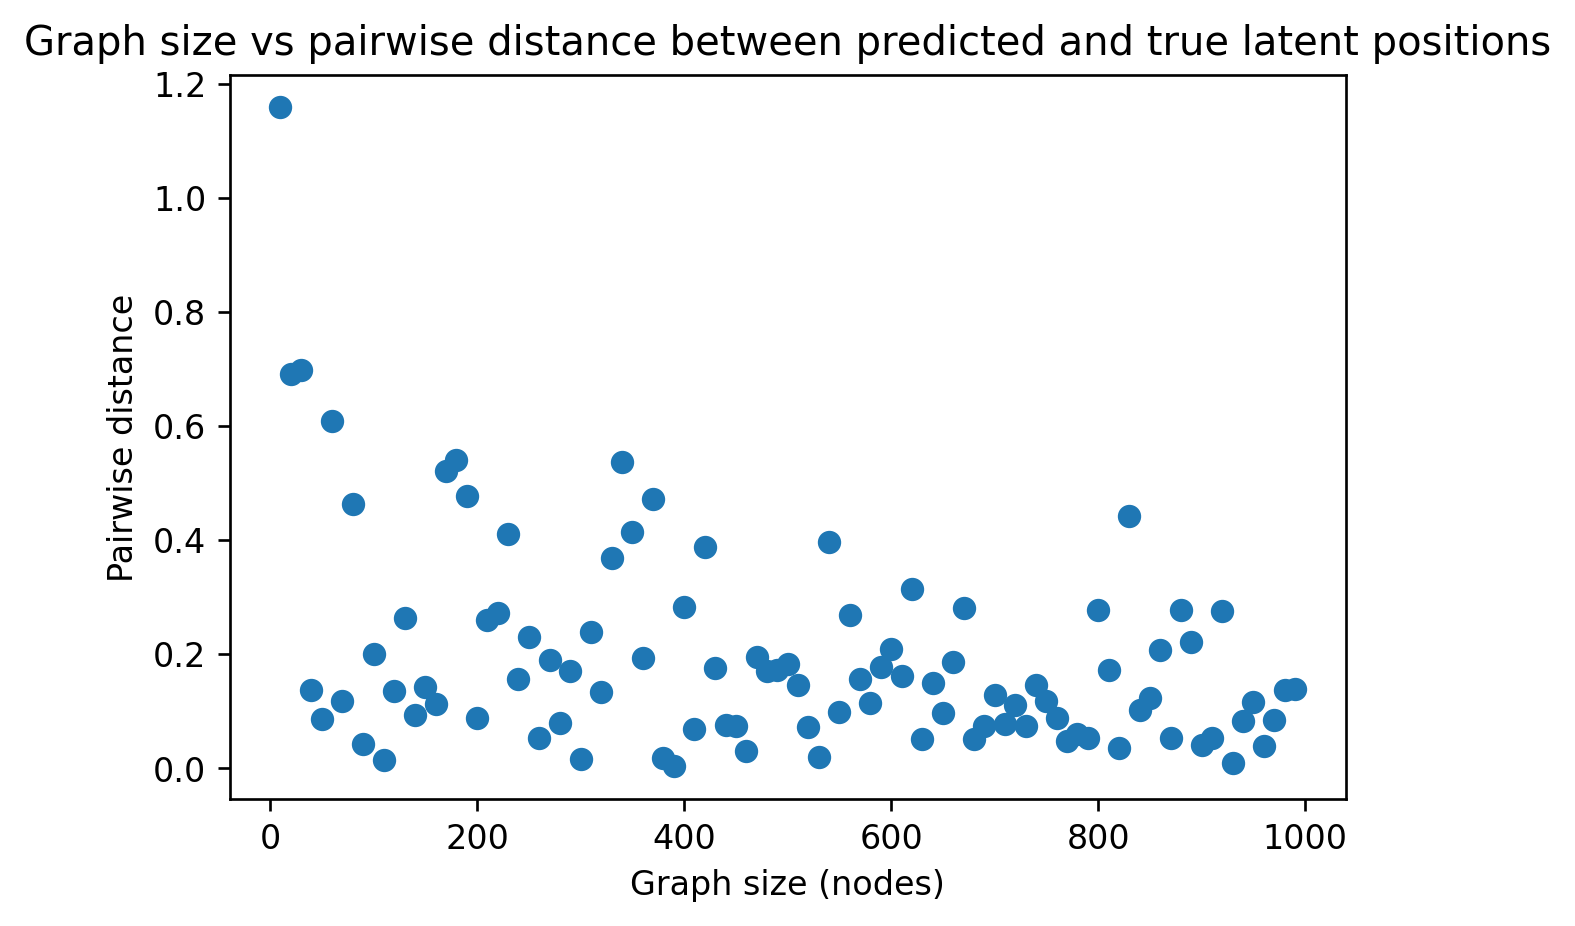

In [66]:
# distances = sorted(distances.items()) # sorted by key, return a list of tuples
x, y = zip(*distances) # unpack a list of pairs into two tuples

# ended up being a shitty graph that doesn't say much
plt.scatter(x, y)
plt.title("Graph size vs pairwise distance between predicted and true latent positions");
plt.xlabel("Graph size (nodes)");
plt.ylabel("Pairwise distance");
plt.savefig("../figs/pairwise_distances.png", dpi=600)

### Start trying to reproduce figure 1

![Figure 1](../figs/figure1_original.png)

Empirical distribution of the LLS OOS estimate for 100 independent trials for number of vertices n = 50 (left), n = 100 (middle) and n = 500 (right). Each plot shows the positions of 100 independent OOS embeddings, indicated by crosses, and colored according to cluster membership. Contours indicate two generalized standard deviations of the multi- variate normal (i.e., 68% and 95% of the probability mass) about the true latent positions, which are indicated by solid circles. We note that even with merely 100 vertices, the normal approximation is already quite reasonable.

In [6]:
# # start with just trying to reproduce for n=50
# import seaborn as sns
# from graspy.simulations import sbm
# from graspy.models import SBMEstimator
# from graspy.plot import heatmap

# from graspy.models.sbm import _get_block_indices, _block_to_full

# # grab a 2-block SBM
# n = 50
# B = np.array([[.53, .34,],
#               [.34, .5125]])
# sbm_graph, labels = sbm([n//2, n//2], B, return_labels=True)

# # stealing pedigo's code
# sbm_model = SBMEstimator(directed=False, loops=True)
# sbm_model.fit(sbm_graph, y=labels)
# sbm_model.block_p_ = B
# _, _, _block_inv = _get_block_indices(labels)
# sbm_model.p_mat_ = _block_to_full(B, _block_inv, sbm_graph.shape)

# # X and Xhat
# X = ase.fit_transform(sbm_model.p_mat_)
# Xhat = ase.fit_transform(sbm_graph)

# applying a rotation that just makes the plots look nicer
# theta = np.radians(-30)
# c, s = np.cos(theta), np.sin(theta)
# R = np.array(((c, -s), (s, c)))
# X = X @ R
# Xhat = Xhat @ R

# plot
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# sns.scatterplot(X[:, 0], X[:, 1], hue=labels, ax=axes[0], palette=["r", "b"]);
# sns.scatterplot(Xhat[:, 0], Xhat[:, 1], hue=labels, ax=axes[1], palette=["r", "b"]);

# axes[0].set_title(r"$\mathbf{X}$");
# axes[1].set_title(r"$\mathbf{\hat{X}}$");

1. consider $F = \lambda \delta_{x1} + (1-\lambda)\delta_{x2}$, with $x_1, x_2 \in \textbf{R}^2$.

Text(0.5, 1.0, 'ASE estimated latent positions vs true latents')

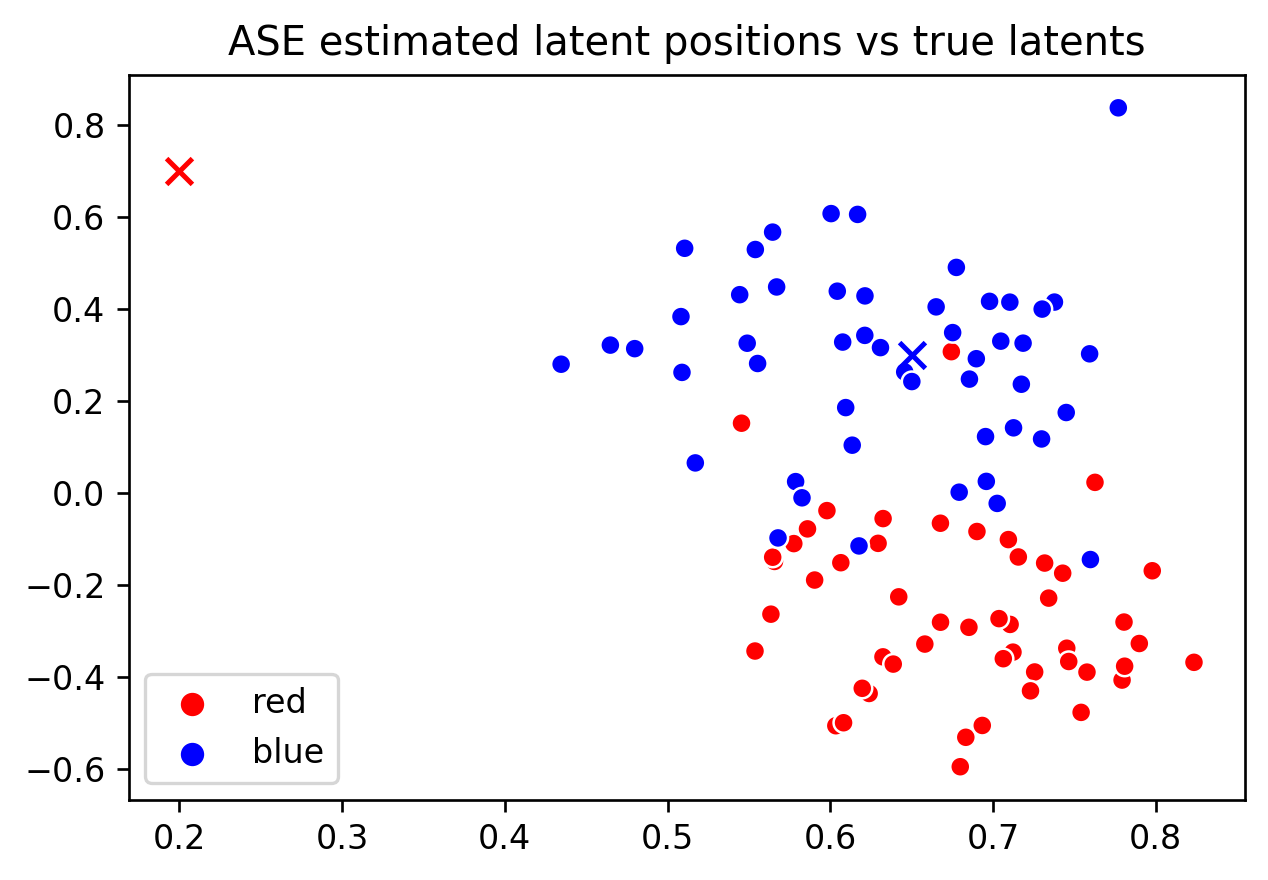

In [92]:
from graspy.simulations import rdpg, sbm
from graspy.plot import pairplot
import pandas as pd
import seaborn as sns

# generate M from rdpg,
# grab true latent positions
n = 50
λ = 0.4
x1 = np.array([.2, .7])
x2 = np.array([.65, .3])
latents = np.vstack((x1, x2))
latents = np.repeat(latents, n, axis=0)
# B = np.array([[x1.T@x1, x1.T@x2],  # if I wanted to do it with sbm
#               [x1.T@x2, x2.T@x2]])

# generate matrix
labels = ["red"]*n + ["blue"]*n
# M = sbm([n, n], B)  # same thing but in sbm form
M = rdpg(latents)

A = M[1:, 1:]  # for oos
a = M[0, 1:]

# embed without oos stuff
ase = AdjacencySpectralEmbed(n_components=2)
ase.fit(M)

# # plot
x, y = ase.latent_left_[:, 0], ase.latent_left_[:, 1]
sns.scatterplot(x, y, hue=labels, palette=['r', 'b'])
plt.gca().scatter(x1[0], x1[1], marker='x', c='r', s=60)  # didn't work
plt.gca().scatter(x2[0], x2[1], marker='x', c='b', s=60)
plt.title("ASE estimated latent positions vs true latents")  # off by a rotation maybe?
# plt.savefig("../figs/estimated_latent_vs_true.png", dpi=600)

# need Procrustes?


# # separate oos vector
# M = sbm(B, loops=False)
# A = M[1:-1, 1:-1]  # in-sample adjacency matrix
# a1 = M[0, 1:-1]  # vector for oos vertex z1, top-left
# a2 = M[-1, 1:-1]  # vector for oos vertex z2, bottom-right
# a = np.row_stack((a1, a2))

# # predicted latent positions
# ase = AdjacencySpectralEmbed(n_components=2)
# ase.fit(A)
# w = ase.predict(a)


# # plotting
# X = np.vstack((X[0], X[-1]))
# X_augmented = np.vstack((X, w))
# x, y = X_augmented[:, 0], X_augmented[:, 1]
# sns.scatterplot(x, y)
# labels = ["blue", "red", "blue oos", "red oos"]

# sns.scatterplot(X_augmented[:, 0], X_augmented[:, 1],
#                 hue=labels, palette=["b", "r", "b", "r"],
#                 linewidth=.3, edgecolor="k",
#                 style=["o", "o", "x", "x"]);
# plt.ylim(0, 1);
# plt.xlim(0, 1);
# plt.title("n=50");

In [94]:
# make a rotation matrix to correct embedding rotation
from scipy.linalg import orthogonal_procrustes

orthogonal_procrustes(ase.latent_left_, B)?

Signature: orthogonal_procrustes(A, B, check_finite=True)
Docstring:
Compute the matrix solution of the orthogonal Procrustes problem.

Given matrices A and B of equal shape, find an orthogonal matrix R
that most closely maps A to B using the algorithm given in [1]_.

Parameters
----------
A : (M, N) array_like
    Matrix to be mapped.
B : (M, N) array_like
    Target matrix.
check_finite : bool, optional
    Whether to check that the input matrices contain only finite numbers.
    Disabling may give a performance gain, but may result in problems
    (crashes, non-termination) if the inputs do contain infinities or NaNs.

Returns
-------
R : (N, N) ndarray
    The matrix solution of the orthogonal Procrustes problem.
    Minimizes the Frobenius norm of ``(A @ R) - B``, subject to
    ``R.T @ R = I``.
scale : float
    Sum of the singular values of ``A.T @ B``.

Raises
------
ValueError
    If the input array shapes don't match or if check_finite is True and
    the arrays contain Inf o

In [53]:
np.unique(latents, axis=0)

array([[0.2 , 0.7 ],
       [0.65, 0.3 ]])

In [50]:
ase.latent_left_

array([[ 0.67511262,  0.33189874],
       [ 0.55469931, -0.12428886],
       [ 0.61018254,  0.44294722],
       [ 0.6690224 ,  0.00253835],
       [ 0.56884737,  0.41444969],
       [ 0.73474641,  0.31554604],
       [ 0.61598247,  0.12145506],
       [ 0.64195967,  0.17685596],
       [ 0.60261411,  0.60998488],
       [ 0.63502329,  0.08879346],
       [ 0.65408619,  0.03771086],
       [ 0.6483294 ,  0.18153521],
       [ 0.68266339,  0.40618261],
       [ 0.67015731,  0.45025513],
       [ 0.67321425,  0.21394918],
       [ 0.7026138 ,  0.20163708],
       [ 0.66872076,  0.39858579],
       [ 0.67073769,  0.30739535],
       [ 0.64853502,  0.48743596],
       [ 0.67650044,  0.38548393],
       [ 0.85274412,  0.61598852],
       [ 0.63375312,  0.49946251],
       [ 0.63184217,  0.17369054],
       [ 0.52151721,  0.16333023],
       [ 0.59634966,  0.17043098],
       [ 0.69364826,  0.56169848],
       [ 0.58798672, -0.01074216],
       [ 0.67880054,  0.03534071],
       [ 0.69819009,